### Reference
https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/maximization_bias.py 

In [3]:
import copy 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

In [49]:
STATE_A = 0
STATE_B = 1
START = STATE_A
STATE_TERMINAL = 2

ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

EPSILON = 0.1 # epsilon-gredy
ALPHA = 0.1   # step size
GAMMA = 1.0   # discount, set to 1 for episodic task

ACTIONS_B = range(0, 10)

STATE_ACTIONS = [
    [ACTION_A_RIGHT, ACTION_A_LEFT], # STATE_A's possible actions
    ACTIONS_B, # STATE_B's possible actions
    [-1], # TERMINAL_STATE's dummy action
]

TRANSITION = [
    [STATE_TERMINAL, STATE_B], # STATE_A's trantions
    [STATE_TERMINAL] * len(ACTIONS_B), # STATE_B's trantions
]

INITIAL_Q = [np.zeros(2), np.zeros(len(ACTIONS_B)), np.zeros(1)]

In [54]:
def choose_action(state, Q):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(STATE_ACTIONS[state])
    else:
        q_values = Q[state]
        return np.random.choice([a for a, val in enumerate(q_values) if val == np.max(q_values)])
        

In [55]:
def step(state, action):
    next_state = TRANSITION[state][action]
    if state == STATE_A:
        reward = 0.
    else:
        reward = np.random.normal(-0.1, 1.)
    return next_state, reward
        

In [56]:
def q_learning(Q):
    state = START
    action = choose_action(state, Q)
    left_count = 0
    while state != STATE_TERMINAL:
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, Q) # not used in the Q(S, A) update
        
        target = np.max(Q[next_state])
        Q[state][action] += ALPHA * (reward + GAMMA * target - Q[state][action])
        
        state = next_state
        action = next_action
        
    return left_count         


In [61]:
def q1_q2_learning(Q1, Q2):
    state = START
    action = choose_action(state, [a1 + a2 for a1, a2 in zip(Q1, Q2)])
    left_count = 0
    while state != STATE_TERMINAL:
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, Q) # not used in the Q(S, A) update

        if np.random.random() < 0.5:
            max_Q = Q1
            target_Q = Q2
        else:
            max_Q = Q2
            target_Q = Q1
            
        best_action = np.random.choice([a for a, val in enumerate(max_Q[next_state]) if val == np.max(max_Q[next_state])])
        target = target_Q[next_state][best_action]
        
        max_Q[state][action] += ALPHA * (reward + GAMMA * target - max_Q[state][action])
                
        state = next_state
        action = next_action
        
    return left_count         
    

In [62]:
num_runs = 10000
num_episodes = 500

left_counts_q_learning = np.zeros((num_runs, num_episodes))
left_counts_q1_q2_learning = np.zeros((num_runs, num_episodes))
for run_idx in tqdm(range(num_runs)):
    Q = copy.deepcopy(INITIAL_Q)
    Q1 = copy.deepcopy(INITIAL_Q)
    Q2 = copy.deepcopy(INITIAL_Q)
    for episode_idx in range(num_episodes):
        left_counts_q_learning[run_idx][episode_idx] = q_learning(Q)
        left_counts_q1_q2_learning[run_idx][episode_idx] = q1_q2_learning(Q1, Q2)

left_counts_q_learning = left_counts_q_learning.mean(axis=0)        
left_counts_q1_q2_learning = left_counts_q1_q2_learning.mean(axis=0)
        

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:28<00:00, 37.29it/s]


In [63]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label1.set_fontsize(x_fontsize)
        tick.label1.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label1.set_fontsize(y_fontsize)
        tick.label1.set_rotation(y_rotation)

Text(0.5, 1.0, 'Maximization bias example')

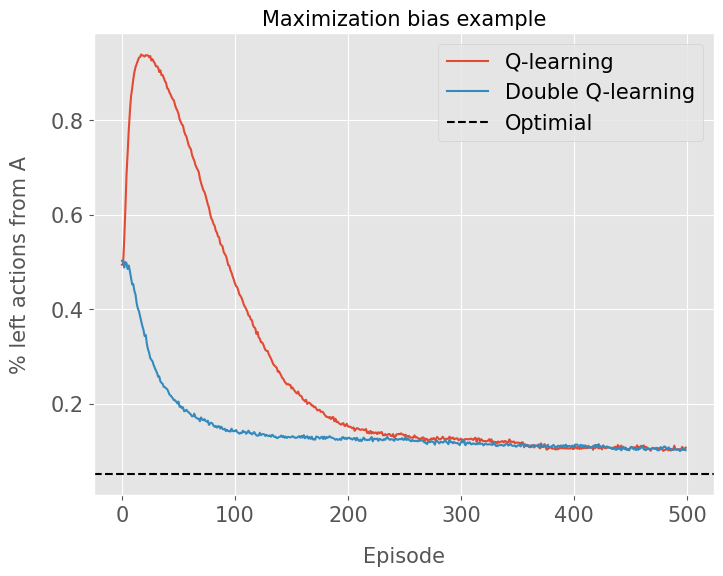

In [64]:
fontsize = 15
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(left_counts_q_learning, label="Q-learning")
ax.plot(left_counts_q1_q2_learning, label="Double Q-learning")
ax.axhline(0.05, ls="--", color="k", label="Optimial")
ax.set_xlabel("Episode", fontsize=fontsize, labelpad=15)
ax.set_ylabel("% left actions from A", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)
ax.legend(loc="best", fontsize=fontsize)
ax.set_title("Maximization bias example", fontsize=fontsize)